Wee will see in this tutrial how to classify cats or dogs from images. We will build an image classifier using a  <font color=blue>tf.keras.Sequential</font> model.

# Import packages
* `os` is used to read files and directory structure
* `Numpy` is used to convert python list to numpy array and perform some matrix operations
* `matplotlib.pyplot` is sed to plot the graph and display images.
* `Tensorflow` and `keras` are used to build the model

In [3]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

# Load data
We will download the [Dogs vs Cats dataset](https://www.kaggle.com/c/dogs-vs-cats/data) from kaggle

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 2s 0us/step


After extracting the contents, we will assign variables with the proper file path for the training and validation set.

In [5]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [6]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

# Unserstand the data
We will see how many images of cats and dogs we have in the training and validation directory

In [7]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [8]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


We can define the parameters that we will use for preprocessing the dataset and training the model

In [12]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Data preparation
We have to transform the images in proper format that can be handled by the neural network:
1. We read the images from the disk
2. We decode the images' contents and convert it into grid format
3. Convert them into floating point tnesors
4. Change the scale values from 0/255 to 0/1.

`tf.keras` provides class for performing these tasks: `ImageDataGenerator`. 

In [13]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

Once we defined the generators for taining and validation images, the `flow_from_directory` method load images from the disk, applies rescaling and resizing.

In [14]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                          directory=train_dir,
                                                          shuffle=True,
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [15]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


# Visualize training images


In [16]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `x_train, y_train`, where x_train is training features and y_train, its labels.

In [17]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

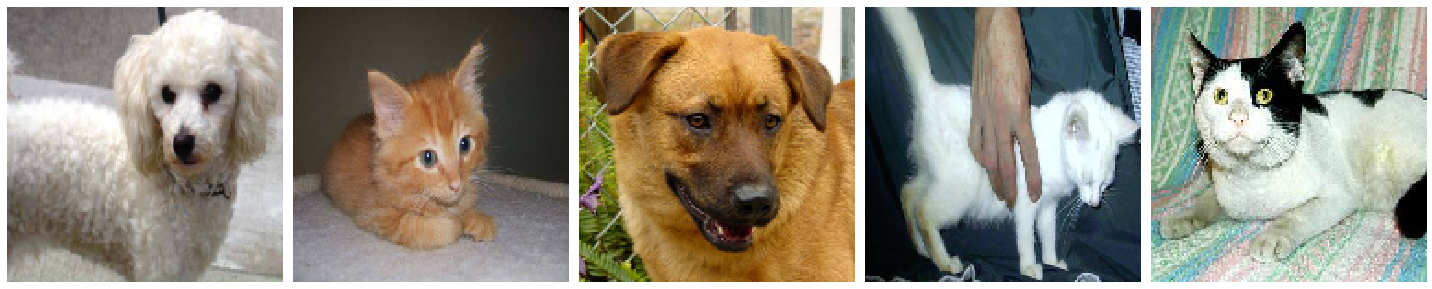

In [18]:
plotImages(sample_training_images[:5])

# Build the model
The model is consistuted of 3 convolution blocks with a max pool layer in each of them and a fully connected layer with 512 units on top with `relu` activation function.

In [19]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

# Compile the model
We will choose *ADAM* optimze,  *binary cross entropy* loss function, and the *accuracy* metric. 

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model summary
We can use the `summary` method to view the complete architecture of the network.

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

# Train the model
We will use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [23]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 7 steps
Epoch 1/15
15/15 [==============================] - 28s 2s/step - loss: 1.1411 - accuracy: 0.5011 - val_loss: 0.6918 - val_accuracy: 0.5022
Epoch 2/15
15/15 [==============================] - 31s 2s/step - loss: 0.6838 - accuracy: 0.5005 - val_loss: 0.6747 - val_accuracy: 0.5022
Epoch 3/15
15/15 [==============================] - 37s 2s/step - loss: 0.6465 - accuracy: 0.5524 - val_loss: 0.6197 - val_accuracy: 0.6786
Epoch 4/15
15/15 [==============================] - 34s 2s/step - loss: 0.5996 - accuracy: 0.6458 - val_loss: 0.5912 - val_accuracy: 0.6607
Epoch 5/15
15/15 [==============================] - 34s 2s/step - loss: 0.5419 - accuracy: 0.7126 - val_loss: 0.5856 - val_accuracy: 0.7254
Epoch 6/15
15/15 [==============================] - 35s 2s/step - loss: 0.5502 - accuracy: 0.7185 - val_loss: 0.6157 - val_accuracy: 

# Visualize training results
Now we visualize the results after training the network

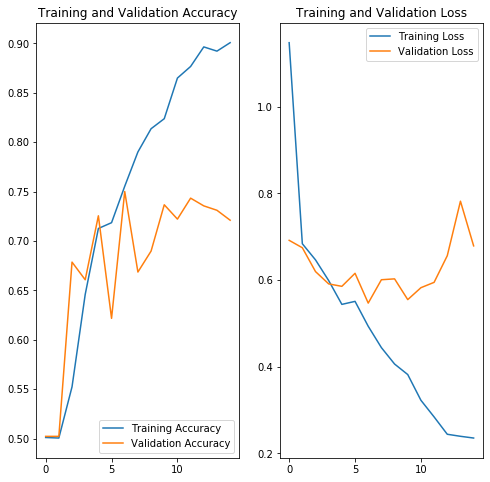

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can notice in the plot that the important difference between the training and validation accuracy. The performance of the model is low since the  training accuracy is 70%. We will see in the next session how to improve the overall performance of the model.

# Overfitting
The difference between the training and validation accuracy represents an *overfitting* phenomenon. This is due to the small number of training examples. Therefore, the model learns from some noises in training examples which decreses its erformance on ne examples.
There are different ways to avoid overfitting during the training phase. We will see in this tutorial how to use: *data augmentation* and adding "dropout" to our model.

## Data augmentation
Overfitting usually happen when we have a small number of training examples. We can decreses overfitting by augmenting the dataset to have more examples. This technique consists on generating more training data based on existing training examples by using random transformations on the images. This halps the model to train based on different aspects of examples and to generalize better.
Data augmentatio can be implmented in `tf.keras` using `ImageDataGenerator` by specifying the multiple transformations that will be applied during the training process.

### Apply horizontal flip
We pass `horizontal_flip` as an argument to the `ImageDataGenerator` class and set it to `True` to apply this augmentation


In [26]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [27]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


In order to visualize the augmentation effect, we will plot one sample image from the training examples and the applied transformation repeated 5 times.

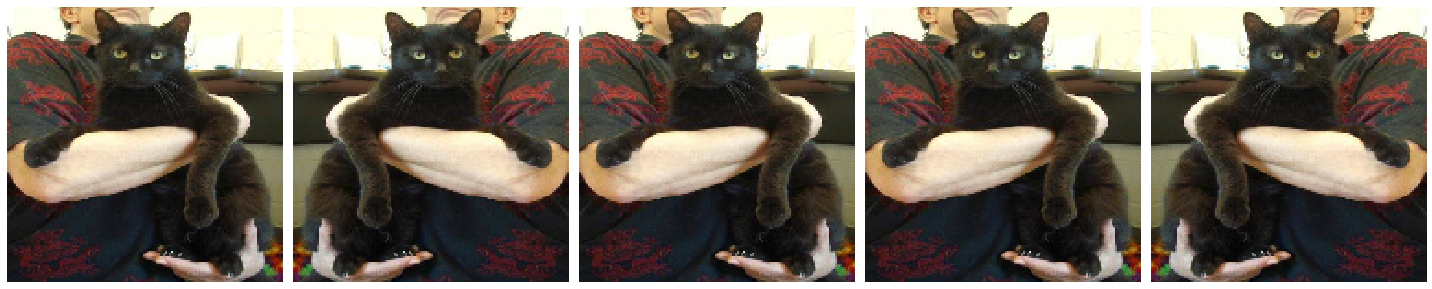

In [28]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Randomly rotate the image
We will see another data augmentation technique that consists on appplying 45 degrees rotation  randomly to the training examples.

In [29]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [30]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


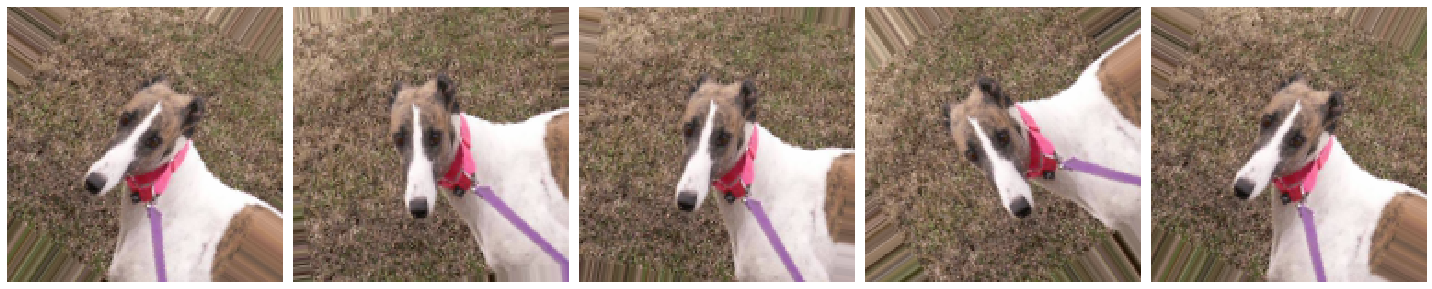

In [31]:
plotImages(augmented_images)

### Zoom
We can apply a zoom augmentation to the dataset randomly (up to 50%)

In [32]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) 

In [33]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


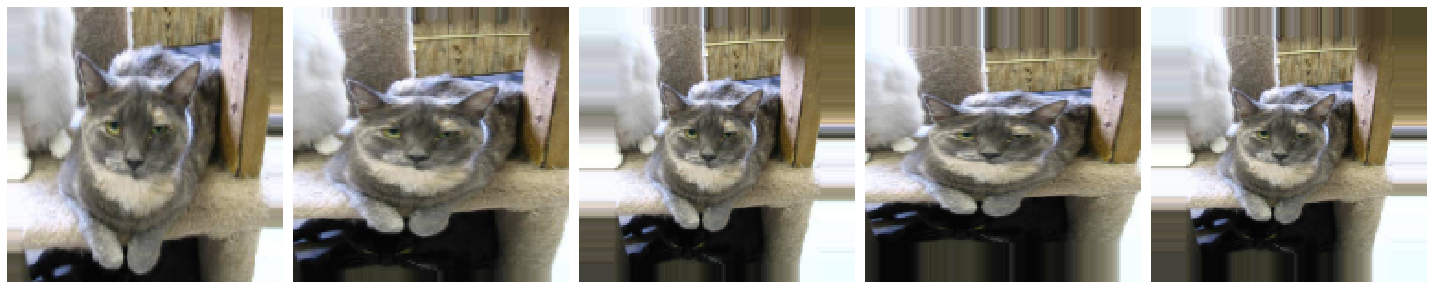

In [34]:
plotImages(augmented_images)

### Mixing different augmentation
We will apply the diffferent augmentation techniques shown above.

In [35]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [36]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Let's see how a single image look five different times when applying these augmentations.

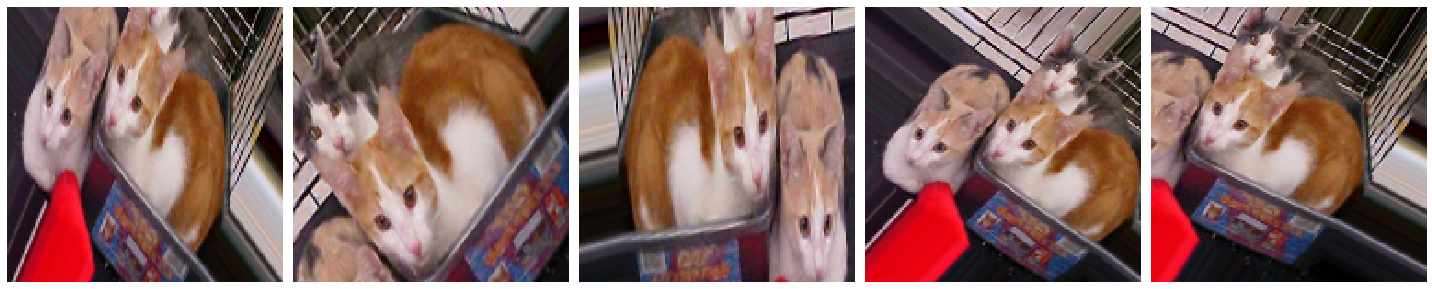

In [37]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Create validation data generator
Generally, we apply data augmentation only to the training examples.

In [38]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [39]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## Dropout
Dropout is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular.
When we apply dropout to a layer it randomly drops ou (set to zero) number of output units frome the applied layer during the training process. Dropout takes a fractional number as input (such as 0.1, 0.2, etc). It means that we will drop out 10% or 20% of the output units randmly from the applied layer for each training epoch.

### Creating a new network with Dropouts
In this example, we will aplly dropout to the first and last max pool layers. It will randomly set 20% of the neurons to zero during each training epoch. This helps to avoid overfitting on the training dataset.

In [40]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

## Compile the  new model

In [41]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

## Train the new model
After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network

In [42]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 7 steps
Epoch 1/15
15/15 [==============================] - 79s 5s/step - loss: 0.8711 - accuracy: 0.5021 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 2/15
15/15 [==============================] - 36s 2s/step - loss: 0.6924 - accuracy: 0.4995 - val_loss: 0.6883 - val_accuracy: 0.5000
Epoch 3/15
15/15 [==============================] - 45s 3s/step - loss: 0.6904 - accuracy: 0.5011 - val_loss: 0.6828 - val_accuracy: 0.5000
Epoch 4/15
15/15 [==============================] - 46s 3s/step - loss: 0.6870 - accuracy: 0.5083 - val_loss: 0.6718 - val_accuracy: 0.5078
Epoch 5/15
15/15 [==============================] - 46s 3s/step - loss: 0.6753 - accuracy: 0.5390 - val_loss: 0.6607 - val_accuracy: 0.5290
Epoch 6/15
15/15 [==============================] - 46s 3s/step - loss: 0.6958 - accuracy: 0.5005 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 7/15
15/15 [==============================] - 47s 3s/step - los

## Vsualize the model
Visualize the new model after training, you can see that there is significantly less overfitting than before. The accuracy should go up after training the model for more epochs

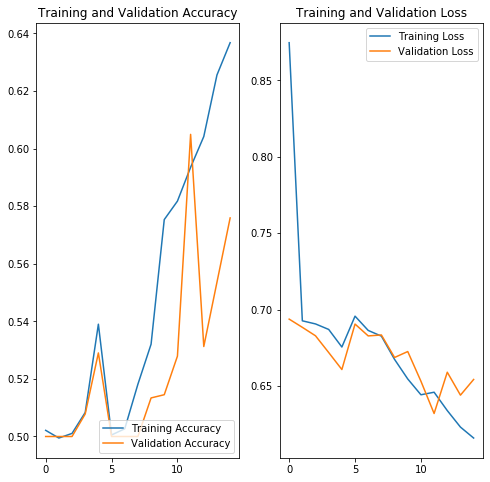

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=30,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 7 steps
Epoch 1/30
15/15 [==============================] - 45s 3s/step - loss: 0.5923 - accuracy: 0.6538 - val_loss: 0.6068 - val_accuracy: 0.6183
Epoch 2/30
15/15 [==============================] - 47s 3s/step - loss: 0.6254 - accuracy: 0.6175 - val_loss: 0.6358 - val_accuracy: 0.5670
Epoch 3/30
15/15 [==============================] - 48s 3s/step - loss: 0.6315 - accuracy: 0.6020 - val_loss: 0.6221 - val_accuracy: 0.5993
Epoch 4/30
15/15 [==============================] - 48s 3s/step - loss: 0.6066 - accuracy: 0.6442 - val_loss: 0.6017 - val_accuracy: 0.6094
Epoch 5/30
15/15 [==============================] - 48s 3s/step - loss: 0.5913 - accuracy: 0.6538 - val_loss: 0.6292 - val_accuracy: 0.5926
Epoch 6/30
15/15 [==============================] - 48s 3s/step - loss: 0.5981 - accuracy: 0.6549 - val_loss: 0.6259 - val_accuracy: 0.5781
Epoch 7/30
15/15 [==============================] - 47s 3s/step - los

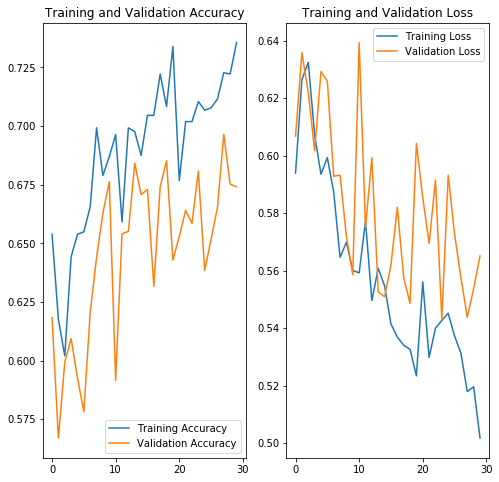

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()